# P3 
**Completed by: Tony Geglio**

Due: Wed. 3/3, 11:59pm

This projects gives you experience with getting data from APIs. 

First, let's get the imports set up

In [ ]:
import pandas as pd 
import requests 
import re 
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import json
import pickle
import datetime
import tweepy

## Getting Some Data 

Since we'll be looking at Twitter data, we need to download the data from Twitter!

Twitter provides an API for downloading tweet data in large batches. The `tweepy` package makes it fairly easy to use.

Follow these instructions to get your keys:

1. [Create a Twitter account](https://twitter.com).  You can use an existing account if you have one.
2. Under account settings, add your phone number to the account.
3. [Create a Twitter developer account](https://dev.twitter.com/resources/signup).  Attach it to your Twitter account.  You should indicate that you are a student and this is to be used for educational purposes (you can mention the class name), that you are not downloading or processing data in bulk.   
4. Once you're logged into your developer account, [create an application for this assignment](https://apps.twitter.com/app/new).  You can call it whatever you want, and you can write any URL when it asks for a web site.
5. On the page for that application, find your Consumer Key and Consumer Secret.
6. On the same page, create an Access Token.  Record the resulting Access Token and Access Token Secret.
7. Edit the file `keys.json` and replace the placeholders with your keys.  **Do not turn in this file.**

### IMPORTANT NOTE.

If someone has your authentication keys, they can access your Twitter account and post as you!  So don't give them to anyone, and **do not write them down in this notebook**.  The usual way to store sensitive information like this is to put it in a separate file and read it programmatically.  That way, you can share the rest of your code without sharing your keys. Preferred method is to put your keys in `keys.json` 

### SECOND IMPORTANT NOTE

Twitter limits developers to a certain rate of requests for data.  If you make too many requests in a short period of time, you'll have to wait awhile (around 15 minutes) before you can make more.  So carefully follow the code examples you see and don't rerun cells without thinking.  Instead, always save the data you've collected to a file.

### Load Key Information 

There are two methods to load your key information. 



#### Method 1: 
Copy and paste the key information (never upload your key information to the Drive). 


In [ ]:
# Method 1 - Get Key Info 
from getpass import getpass
keys = {}
keys["consumer_key"] = getpass("Enter Twitter Consumer Key:    ")
keys["consumer_secret"] = getpass("Enter Twitter Consumer Secret: ")
keys["access_token"] = getpass("Enter Twitter Access Token:    ")
keys["access_token_secret"] = getpass("Enter Twitter Access Token Secret: ")


Enter Twitter Consumer Key:    ··········
Enter Twitter Consumer Secret: ··········
Enter Twitter Access Token:    ··········
Enter Twitter Access Token Secret: ··········


#### Method 2 

Load `keys.json` to Colab directory (file is destroyed when sevice is disconnected).  This method relys on Google's security for safely storing and protecting your data. 

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
with open("keys.json") as f:
  keys = json.load(f)    

## Function to search for last 30 days of tweets

The functions below are designed to load recent tweets by using a query.   

In [ ]:
def download_recent_tweets(search_query,items, keys): 

  #Authenticate
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth)
  # Getting as many recent tweets by @user as Twitter will let us have 
#   return list(tweepy.Cursor(api.user_timeline, id=user_account_name).items())
    return list(tweepy.Cursor(api.search_30_day, environment_name= 'projects', query=f"{search_query} lang: en").items(items))

def save_tweets(tweets, path):  
    with open(path, "wb") as f:
        import pickle
        pickle.dump(tweets, f)

def load_tweets(path):
    with open(path, "rb") as f:
        import pickle
        return pickle.load(f)

def get_tweets_with_cache(search_query,items, keys): 
    save_path = "{}_recent_tweets.pkl".format(search_query)
    from pathlib import Path 
    if not Path(save_path).is_file():
        tweets = download_recent_tweets(search_query,items, keys)
        save_tweets(tweets, save_path)
    return load_tweets(save_path)



Inspect several of the tweet objects, see what form they take what information is stored, where it is stored. 

https://www.geeksforgeeks.org/extracting-tweets-containing-a-particular-hashtag-using-python/

In [ ]:
# Looking at one tweet object, which has type Status: 
def make_tweet_df(tweets):
    # Creating DataFrame using pandas
    df = pd.DataFrame(columns=['username', 'sensitive','description',
                                'following','followers','totaltweets',
                                'text','language'])
    # not used for now: 'location', #'retweetcount', #'hashtags',
                            
    for t in tweets:
        try:
            username = t.user.screen_name
            sensitive = t.possibly_sensitive
            description = t.user.description
            location = t.user.location
            following = t.user.friends_count
            followers = t.user.followers_count
            totaltweets = t.user.statuses_count
            retweetcount = t.retweet_count
            text = t.text
            hashtags = t.entities['hashtags']
            language = t.lang

            ith_tweet = [username, sensitive, description,
                        following, followers, totaltweets,
                        text, language]
                        #location, #retweetcount, #hashtext 
                        
            df.loc[len(df)] = ith_tweet
        except: pass
    return df


In [ ]:
#war_tweets = get_tweets_with_cache("war",1000, keys)
news_tweets = load_tweets('News_tweets1.pkl')
war_tweets = load_tweets('war_recent_tweets.pkl')

df_news = make_tweet_df(news_tweets)
df_news = df_news.loc[df_news['language'] == "en"]
print(df_news['sensitive'].value_counts())

False    268
True       6
Name: sensitive, dtype: int64


In [ ]:
covid_tweetstest = get_tweets_with_cache("corona",100, keys)

In [ ]:
df_covid = make_tweet_df(covid_tweetstest)

In [ ]:
print(df_covid[df_covid['sensitive']==True]['text'].values)

['Holy hibiscus honey bunnies Megan and Sarah I have given up on hoping to find anyone lovable that would fall in lov… https://t.co/rrmd23KMZg'
 'Why catch Corona in a crowded airport, when you can catch Fiends in FFX for CASH!? Lets do eet!… https://t.co/7J9PwjFh1R'
 'RT @DigitSlayer: From the depths of Aliexpress.\nThis will be all the rage during Corona... https://t.co/ix45BbTQ7L']


In [ ]:
df_war = make_tweet_df(war_tweets)
df_war = df_war.loc[df_war['language'] == "en"]
print(df_war['sensitive'].value_counts())

False    117
True       6
Name: sensitive, dtype: int64


Understanding the tweet structure is hard, especially when the information is all printed in a single line.  pprint can make this a bit easier to read. 

In [ ]:
import pprint
pprint.pprint(vars(example_tweets[1]))

## Exploring the dataset 
## Below this point is in progress

Twitter gives us a lot of information about each tweet, not just the tweet itself.  You can read the full documentation [here](https://dev.twitter.com/overview/api/tweets).  Look at the one tweet aboe to get a sense of the information we have available. 



### Q3 - (15 pts) 

Which fields contain: 

1. the actual text of a tweet, 
2. the time when the tweet was posted, 
3. the source (device and app) from which the tweet was posted, 
4. the number of times the tweet was favorited, 
5. the number of times a tweet is retweeted?

To answer the question, write functions that extract each field from a tweet.  Each function should take a single tweet (Status object) as its argument. 

In [ ]:
def extract_text(tweet): 
    # BEGIN SOLUTION 
  tweet = tweet.text
  return tweet
    #END SOLUTION 

def extract_time(tweet): 
    # BEGIN SOLUTION 
    times = (tweet.created_at)
    times = datetime.datetime.strftime(times,'%H:%M:%S')
    
    return times
    #END SOLUTION

def extract_source(tweet):
    # BEGIN SOLUTION 
    source = tweet.source
    return source
    #END SOLUTION

def extract_fav_num(tweet):
    # BEGIN SOLUTION 
    fav = tweet.favorite_count
    return fav
    #END SOLUTION

def extract_retweet_num(tweet):
    # BEGIN SOLUTION 
    rt = tweet.retweet_count
    return rt
    #END SOLUTION


Create a plot showing how many tweets came from each kind of source for the account you chose. 

In [ ]:
stc

,favNum,retweetNum
source,,
Camera on iOS,7889,7923
Instagram,650,256
Mobile Web,1869,10593
Mobile Web (M2),13871,8247
Twitter Web App,94820,45933
Twitter Web Client,174025,266354
Twitter for Android,2574921,1172636
Twitter for BlackBerry®,16689,84706
Twitter for Websites,356,736


Text(0.5, 0, 'Count x 10^7')

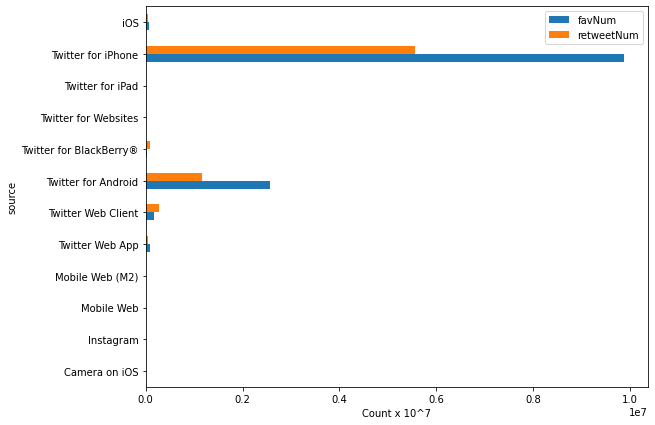

In [ ]:
### BEGIN SOLUTION 
 
stc = weezy_df.groupby('source').sum()
stc.plot(figsize = (9,7), kind='barh')
plt.xlabel('Count x 10^7')
### END SOLUTION 

## Examining Text

The following questions comes from [https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-frequencies-in-python/](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-frequencies-in-python/)

Here is a function that removes the URLs (links) and emojis from the tweet text. By running the code that follows this function you should have then "cleanish" text.  *Note, it may not eliminate all emojis*

In [ ]:
import re 

In [ ]:
def remove_url(txt): 
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).
    Also, replaces the emoji with nothing. 

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """
    txt2 = re.sub('http[s]?://\S+', '', txt)
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    txt2 = re.sub(emoji_pattern, '', txt2)
    return txt2


This gets the text for the @Dodgers tweets.

In [ ]:
dodTweets = [tweet.text for tweet in dodgers]
dodTweets_no_urls = [remove_url(tweet) for tweet in dodTweets]
dodTweets_no_urls[0:4]

['@Mathieu_Diano 🤝',
 '@WeThaChxmps YOU’RE WELCOME.',
 'The Champs are putting on a clinic. ',
 '@marieelxo Happy birthday!']

Now do the same thing for the account of your choosing.

In [ ]:
weezyText = [tweet.text for tweet in weezy]
weezyText_no_urls = [remove_url(tweet) for tweet in weezyText]
weezyText_no_urls[0:10]

['Sourdough @BurgerKing #AD',
 'Real G’z move in silence like....',
 'Slime walked off to “Wanna be a baller” after knokkin son out!🤦\u200d pour up. I’m bout to listen to Dat sh!t all night',
 'Dat man said dats herb dean fault!🤦\u200d\nMan slime is still unconscious as I write dis!!! Bruh I been tellin y’a… ',
 'Fkn Black Beast!!!!!!',
 '“Big Tipper” video OUT NOW!!! @torylanez @Melii ',
 'In the studio in “momma there go dat man” mode...stay home. 🤫🤯🥶🤖 Slatt🤧',
 '',
 'GO PACK GO!!!!!!!!',
 'GO PACK GO!!!!!!!!!!!! ']

Write code that will take your list of tweet text (`dodTweets_no_urls` for the @Dodgers tweets) and creates a list of lists containing the lower case words for each tweet. 

*Hint:* you may want to think about performing the operations on a single tweet text `dodTweets_no_urls[0]` - convert it to all lower case, break it into individual words.  Think about String methods [https://docs.python.org/3.7/library/stdtypes.html#string-methods](https://docs.python.org/3.7/library/stdtypes.html#string-methods)

*Hint:* Once you get the list of words from a single tweet text, collect all the tweet's texts in another list. 

```
[['test', 
  'string', 
  'text'],
 ['hello', 
  'world']]
```

Show `words_in_tweets` for your chosen account.

In [ ]:
words_in_tweets = []
for i in range(len(weezyText_no_urls)):
  words_in_tweets.append(weezyText_no_urls[i].lower().split(' '))

words_in_tweets[:3]

[['sourdough', '@burgerking', '#ad'],
 ['real', 'g’z', 'move', 'in', 'silence', 'like....'],
 ['slime',
  'walked',
  'off',
  'to',
  '“wanna',
  'be',
  'a',
  'baller”',
  'after',
  'knokkin',
  'son',
  'out!🤦\u200d',
  'pour',
  'up.',
  'i’m',
  'bout',
  'to',
  'listen',
  'to',
  'dat',
  'sh!t',
  'all',
  'night']]

### Q7 - (10 pts) 

Write code to take your list of lists of words and count the number of times each word appears.

You may want to look at using `itertools` to flatten the list. Also, look at the built-in Python library `collections`, which helps create a special type of a Python dictonary. The `collection.Counter` object has a useful built-in method `most_common` that will return the most commonly used words and the number of times that they are used.

https://towardsdatascience.com/pythons-collections-module-high-performance-container-data-types-cb4187afb5fc

In [ ]:
import itertools 
import collections 
from collections import Counter

merged = list(itertools.chain(*words_in_tweets))
cd = Counter(merged)
cd.most_common(15)


[('', 1629),
 ('the', 680),
 ('to', 545),
 ('i', 452),
 ('my', 366),
 ('and', 355),
 ('a', 351),
 ('for', 294),
 ('on', 288),
 ('in', 254),
 ('go', 248),
 ('of', 199),
 ('is', 189),
 ('was', 183),
 ('rt', 167)]

### Q8 - (10 pts) 

Plot the top 30 most frequently used words with their word counts. 

*Hint:* You may want to import the information from above into a Dataframe and use your normal plotting tools

  WeezyFavWords  WeezyCount
0                      1629
1           the         680
2            to         545
3             i         452
4            my         366


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text major ticklabel objects>)

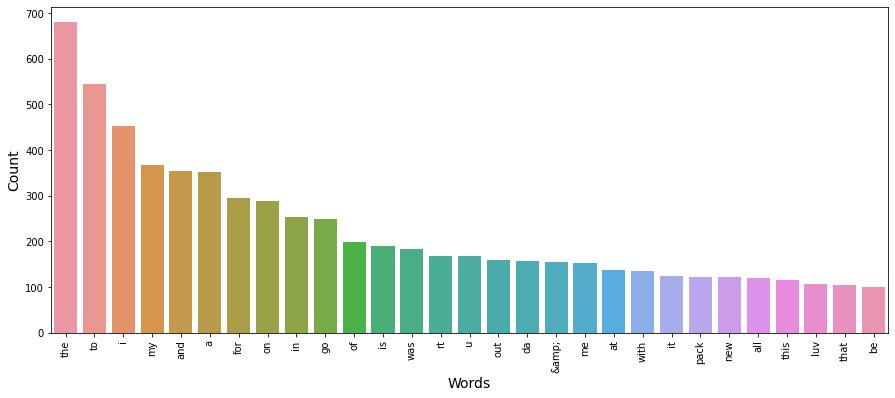

In [ ]:
WeezysTop = pd.DataFrame(cd.most_common(len(cd)), columns=['WeezyFavWords', 'WeezyCount'])
print(WeezysTop.head())
#WeezysTop[0:30].plot(kind = 'bar', figsize = (15,7))
import seaborn as sns
plt.figure(figsize=(15, 6))
sns.barplot(x="WeezyFavWords",y="WeezyCount",data=WeezysTop[1:30])
plt.xlabel("Words", size=14)
plt.ylabel("Count", size=14)
plt.xticks(rotation = 90)


You may see a number of very common words as the most common, e.g., the, in, to, of, etc. You may want to remove those common words, these are typically referred to as "stop words" in the text analysis communities.

The python package `nltk` is used for text analysis. It provides a list of "stop words". Re-analyze the tweet text by removing stop words from consideration, and plot the 30 most popular words with their frequencies.

In [ ]:
import nltk

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
WeezysTop.iloc[1]['WeezyFavWords']

'the'

In [ ]:
len(WeezysTop)

500

In [ ]:
filtered_WeezyFavWords = []
filtered_WeezyCount = []
filt_WeezysTop = pd.DataFrame(columns=['WeezyFavWords', 'WeezyCount'])
for i in range(len(WeezysTop)):
  count = WeezysTop.iloc[i]['WeezyCount']
  word = WeezysTop.iloc[i]['WeezyFavWords']   
  if word not in stopwords.words('english'):  
    filtered_WeezyFavWords.append(word)
    filtered_WeezyCount.append(count)

filt_WeezysTop['WeezyFavWords'] = filtered_WeezyFavWords
filt_WeezysTop['WeezyCount'] = filtered_WeezyCount
filt_WeezysTop[1:30]

,WeezyFavWords,WeezyCount
1,go,248
2,rt,167
3,u,167
4,da,157
5,&amp;,154
6,pack,122
7,new,121
8,luv,106
9,i'm,88
10,@liltunechi,85


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text major ticklabel objects>)

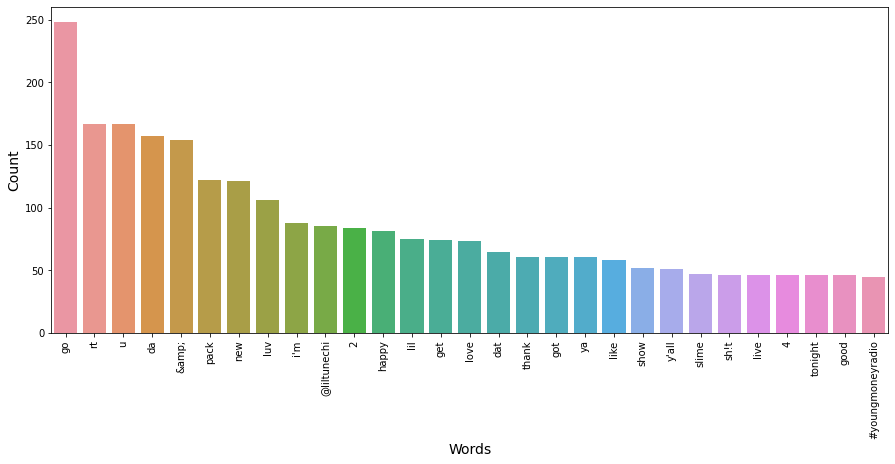

In [ ]:
plt.figure(figsize=(15, 6))
sns.barplot(x="WeezyFavWords",y="WeezyCount",data=filt_WeezysTop[1:30])
plt.xlabel("Words", size=14)
plt.ylabel("Count", size=14)
plt.xticks(rotation = 90)